# Homework 6
In this homework, we will implement a simplified version of object detection process. Note that the tests on the notebook are not comprehensive, autograder will contain more tests.

In [1]:
from __future__ import print_function
import random 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io
from skimage.feature import hog
from skimage import data, color, exposure
from skimage.transform import rescale, resize, downscale_local_mean
import glob, os
import fnmatch
import time

import warnings
warnings.filterwarnings('ignore')

from detection import *
from visualization import *
from utils import *

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Part 1: Hog Representation (5 points)

In this section, we will compute the average hog representation of human faces.<br>
There are 31 aligned face images provided in the `\face` folder. They are all aligned and have the same size. We will get an average face from these images and compute a hog feature representation for the averaged face. <br>
Use the hog function provided by skimage library, and implement a hog representation of objects.
Implement **`hog_feature`** function in `detection.py`

Sum of face feature =  499.9704572768695


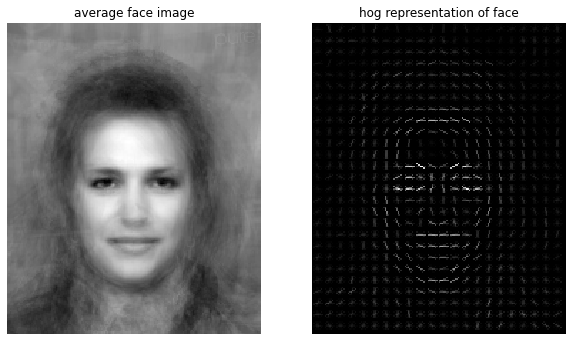

In [2]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')
list.sort(image_paths)
n = len(image_paths)
face_shape, avg_face = load_faces(image_paths, n)

(face_feature, hog_image) = hog_feature(avg_face)

print("Sum of face feature = ", np.sum(face_feature))
assert np.abs(np.sum(face_feature) - 499.970465079) < 1e-2

plot_part1(avg_face, hog_image)

# Part 2: Sliding Window (20 points)
Implement **`sliding_window`** function to have windows slide across an image with a specific window size. The window slides through the image and checks if an object is detected with a high similarity score with the template at every location. We compute these scores as the dot product of the HoG features of the template and the HoG features of each window as the windows slide through the image. These scores will generate a response map and you will be able to find the location of the window with the highest hog score. 


(218, 178)
Maximum HOG face feature score over sliding window =  7.575585018614379
Maximum score location = row 150, col 270


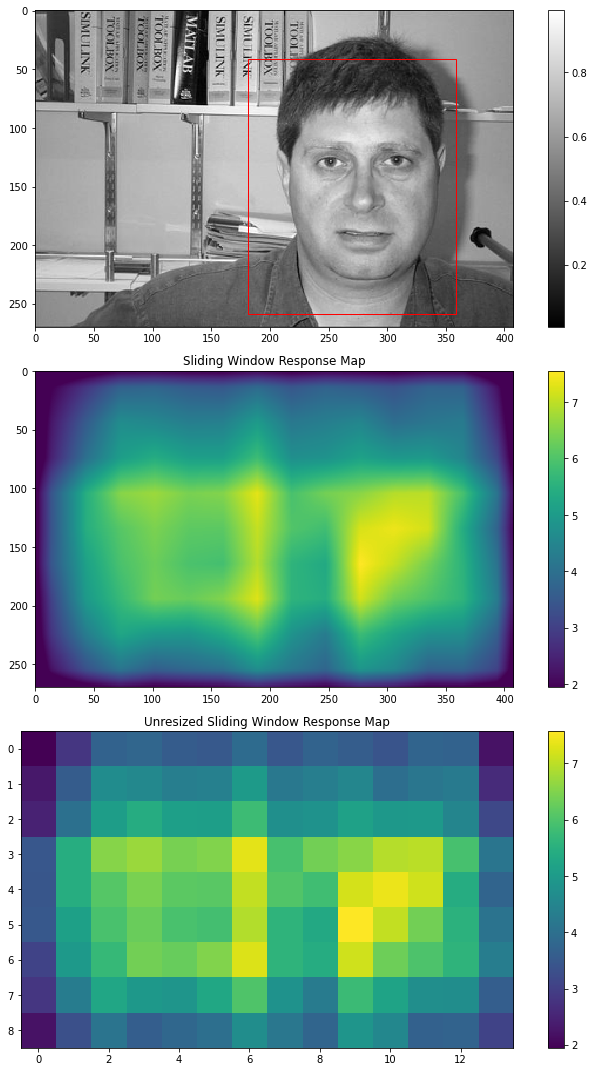

In [3]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 0.8)

(winH, winW) = face_shape
print(face_shape)
(score, r, c, response_map_resized, response_map) = \
    sliding_window(image, face_feature, step_size=30, window_size=face_shape, return_unresized_response=True)

print("Maximum HOG face feature score over sliding window = ", score)
print("Maximum score location = row {}, col {}".format(r, c))
crop = image[r:r+winH, c:c+winW]
plot_part2(image, r, c, response_map_resized, response_map, winW, winH)

Sliding window successfully found the human face in the above example. However, in the cell below, we are only changing the scale of the image, and you can see that sliding window does not work once the scale of the image is changed. 

Maximum HoG face feature score over sliding window =  7.79655483261252
Maximum score location = row 180, col 270


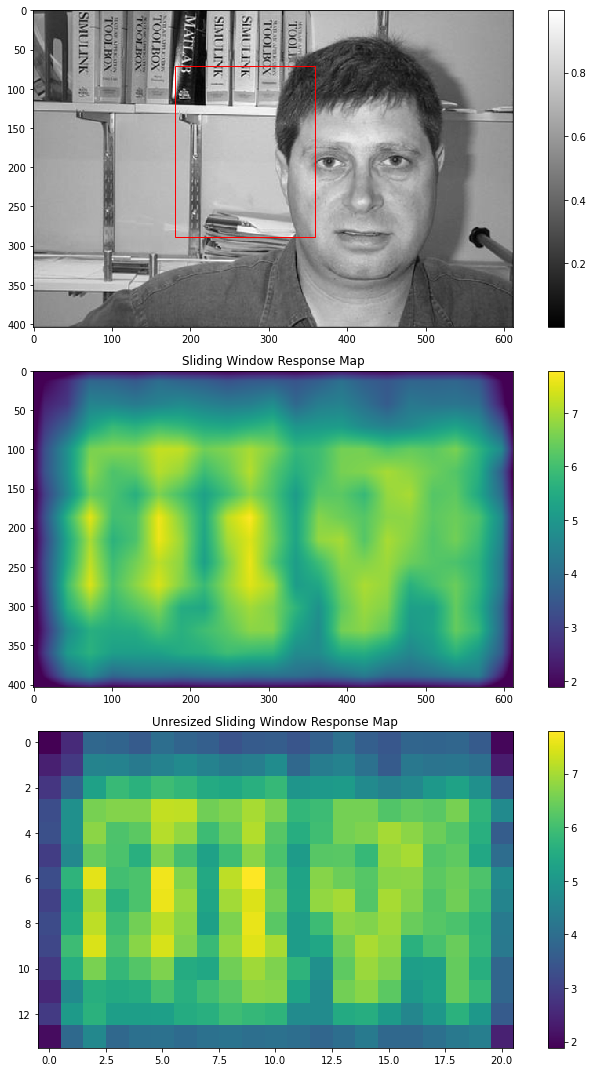

In [4]:
image_path = 'image_0001.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
(score, r, c, response_map_resized, response_map) = \
    sliding_window(image, face_feature, step_size=30, window_size=face_shape, return_unresized_response=True)

print("Maximum HoG face feature score over sliding window = ", score)
print("Maximum score location = row {}, col {}".format(r, c))
crop = image[r:r+winH, c:c+winW]
plot_part2(image, r, c, response_map_resized, response_map, winW, winH)

# Part 3: Image Pyramids (20 points)
In order to make sliding window work for different scales of images, you need to implement image pyramids where you resize the image to different scales and run the sliding window method on each resized image. This way you scale the objects and can detect both small and large objects. 


###  3.1 Image Pyramid (5 points)

Implement **`pyramid`** function in `detection.py`, this will create pyramid of images at different scales. Run the following code, and you will see the shape of the original image gets smaller until it reaches a minimum size.


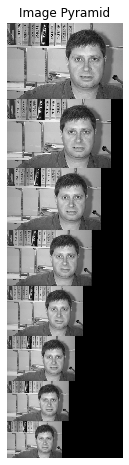

In [5]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

images = pyramid(image, scale = 0.9)

plot_part3_1(images)

###  3.2 Pyramid Score (15 points)

After getting the image pyramid, we will run sliding window on all the images to find a place that gets the highest score. Implement **`pyramid_score`** function in `detection.py`. It will return the highest score and its related information in the image pyramids.

Maximum HoG face feature score over pyramid and sliding window =  8.256817582542322
Maximum score location = row 150, col 270


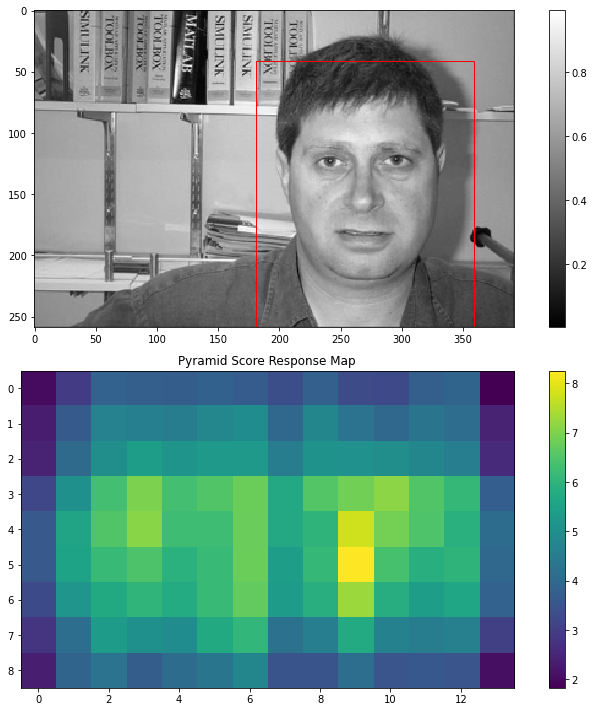

In [6]:
image_path = 'image_0001.jpg'

image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.2)

(winH, winW) = face_shape
max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
        (image, face_feature, face_shape, step_size = 30, scale=0.8)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(maxr, maxc))
plot_part3_2(image, max_scale, winW, winH, maxc, maxr, max_response_map)

From the above example, we can see that image pyramid has fixed the problem of scaling. Then in the example below, we will try another image and implement a deformable parts model.

Maximum HoG face feature score over pyramid and sliding window =  8.844758343263585
Maximum score location = row 90, col 90


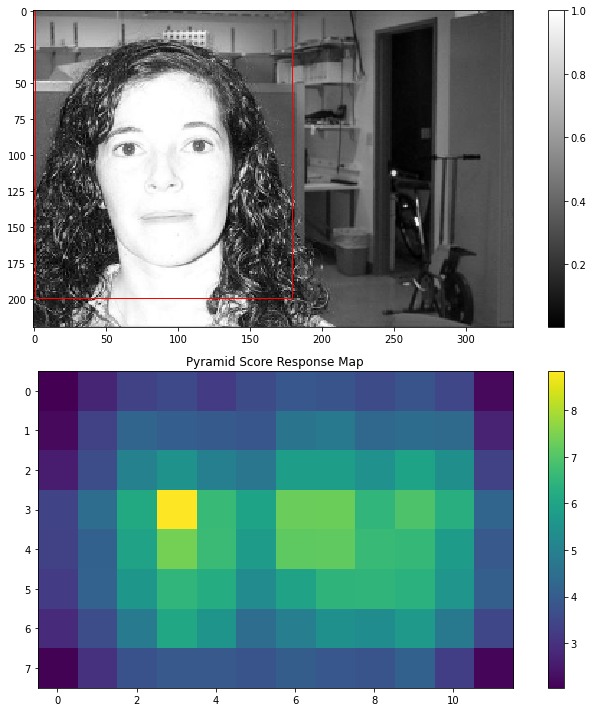

In [7]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(winH, winW) = face_shape

max_score, maxr, maxc, max_scale, max_response_map = pyramid_score \
    (image, face_feature, face_shape, step_size = 30, scale=0.8)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(maxr, maxc))
plot_part3_2(image, max_scale, winW, winH, maxc, maxr, max_response_map)

# Part 4: Deformable Parts Detection (15 Points)
In order to solve the problem above, you will implement deformable parts model in this section, and apply it on human faces. <br>
The first step is to get a detector for each part of the face, including left eye, right eye, nose and mouth. <br>
For example for the left eye, we have provided the groundtruth location of left eyes for each image in the `\face` directory. This is stored in the `lefteyes` array with shape `(n,2)`, each row is the `(r,c)` location of the center of left eye. You will then find the average hog representation of the left eyes in the images.

Run through the following code to get a detector for left eyes.

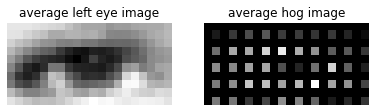

In [8]:
image_paths = fnmatch.filter(os.listdir('./face'), '*.jpg')

parts = read_facial_labels(image_paths)
lefteyes, righteyes, noses, mouths = parts

# Typical shape for left eye
lefteye_h = 10
lefteye_w = 20

lefteye_shape = (lefteye_h, lefteye_w)

avg_lefteye = get_detector(lefteye_h, lefteye_w, lefteyes, image_paths)
(lefteye_feature, lefteye_hog) = hog_feature(avg_lefteye, pixel_per_cell=2)

plot_part4(avg_lefteye, lefteye_hog, 'left eye')

Run through the following code to get a detector for right eye.

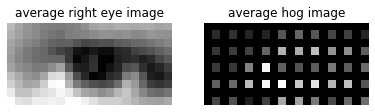

In [9]:
righteye_h = 10
righteye_w = 20

righteye_shape = (righteye_h, righteye_w)

avg_righteye = get_detector(righteye_h, righteye_w, righteyes, image_paths)

(righteye_feature, righteye_hog) = hog_feature(avg_righteye, pixel_per_cell=2)

plot_part4(avg_righteye, righteye_hog, 'right eye')

Run through the following code to get a detector for nose.

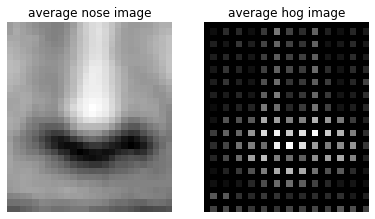

In [10]:
nose_h = 30
nose_w = 26

nose_shape = (nose_h, nose_w)

avg_nose = get_detector(nose_h, nose_w, noses, image_paths)

(nose_feature, nose_hog) = hog_feature(avg_nose, pixel_per_cell=2)

plot_part4(avg_nose, nose_hog, 'nose')

Run through the following code to get a detector for mouth

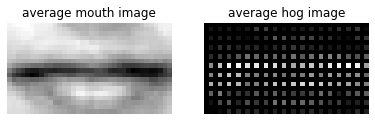

In [11]:
mouth_h = 20
mouth_w = 36

mouth_shape = (mouth_h, mouth_w)

avg_mouth = get_detector(mouth_h, mouth_w, mouths, image_paths)

(mouth_feature, mouth_hog) = hog_feature(avg_mouth, pixel_per_cell=2)

detectors_list = [lefteye_feature, righteye_feature, nose_feature, mouth_feature]

plot_part4(avg_mouth, mouth_hog, 'mouth')

###  4.1 Compute displacement (10 points)

Implement **`compute_displacement`** to get an average shift vector mu and standard deviation sigma for each part of the face. The vector mu is the distance from the main center, i.e the center of the face, to the center of the part. Note that you can and should leave mu as a decimal instead of rounding to integers, because our next step of applying the shift in **`shift_heatmap`** will interpolate the shift, which is valid for decimal shifts.


In [12]:
# test for compute_displacement
test_array = np.array([[0,1],[1,2],[2,3],[3,4]])
test_shape = (6,6)
mu, std = compute_displacement(test_array, test_shape)
assert(np.all(mu == [1.5,0.5]))
assert(np.sum(std-[ 1.11803399,  1.11803399])<1e-5)
print("Your implementation is correct!")

Your implementation is correct!


In [13]:
lefteye_mu, lefteye_std = compute_displacement(lefteyes, face_shape)
righteye_mu, righteye_std = compute_displacement(righteyes, face_shape)
nose_mu, nose_std = compute_displacement(noses, face_shape)
mouth_mu, mouth_std = compute_displacement(mouths, face_shape)

print("Left eye shift = ", lefteye_mu)
print("Right eye shift = ", righteye_mu)
print("Nose shift = ", nose_mu)
print("Mouth shift = ", mouth_mu)

print("\nLeft eye std = ", lefteye_std)
print("Right eye std = ", righteye_std)
print("Nose std = ", nose_std)
print("Mouth std = ", mouth_std)

Left eye shift =  [-2.29032258 19.77419355]
Right eye shift =  [ -2.16129032 -18.83870968]
Nose shift =  [-26.48387097   0.80645161]
Mouth shift =  [-42.80645161   0.93548387]

Left eye std =  [1.22325711 1.38446863]
Right eye std =  [0.62716845 1.62831348]
Nose std =  [4.34682656 5.17075745]
Mouth std =  [1.4009065  0.71551848]


After getting the shift vectors, we can run our detector on a test image. We will first run the following code to detect each part of left eye, right eye, nose and mouth in  the image. You will see a response map for each of them.

Maximum HoG face feature score over pyramid and sliding window =  8.844758343263585
Maximum score location = row 90, col 90


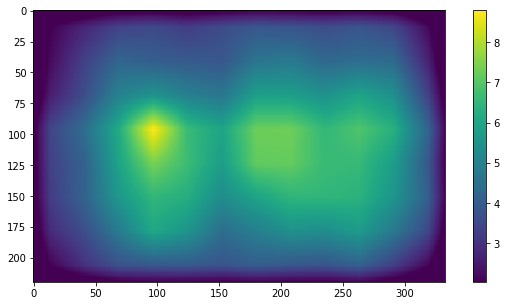

In [36]:
image_path = 'image_0338.jpg'
image = io.imread(image_path, as_gray=True)
image = rescale(image, 1.0)

(face_H, face_W) = face_shape
max_score, face_r, face_c, face_scale, face_response_map = pyramid_score\
    (image, face_feature, face_shape,step_size = 30, scale=0.8)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(face_r, face_c))
plot_part5_1(face_response_map)

Maximum HoG face feature score over pyramid and sliding window =  0.9617832180927588
Maximum score location = row 40, col 200


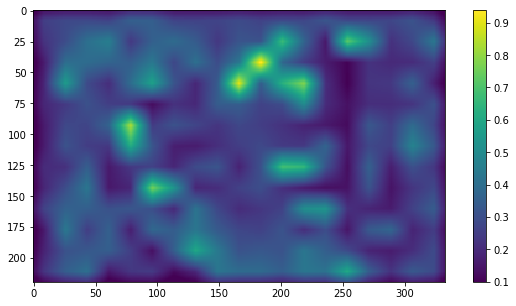

In [37]:
max_score, lefteye_r, lefteye_c, lefteye_scale, lefteye_response_map = \
    pyramid_score(image, lefteye_feature,lefteye_shape, step_size = 20,scale=0.9, pixel_per_cell = 2)

lefteye_response_map = resize(lefteye_response_map, face_response_map.shape)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(lefteye_r, lefteye_c))
plot_part5_1(lefteye_response_map)

Maximum HoG face feature score over pyramid and sliding window =  0.8716379302278094
Maximum score location = row 40, col 200


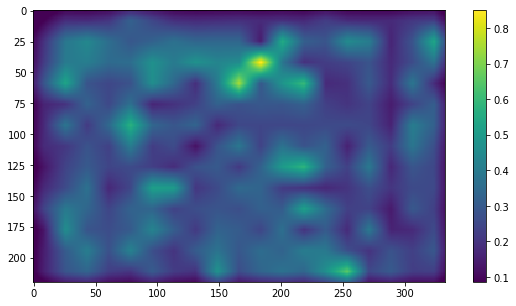

In [38]:
max_score, righteye_r, righteye_c, righteye_scale, righteye_response_map = \
    pyramid_score (image, righteye_feature, righteye_shape, step_size = 20,scale=0.9, pixel_per_cell=2)

righteye_response_map = resize(righteye_response_map, face_response_map.shape)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(righteye_r, righteye_c))
plot_part5_1(righteye_response_map)

Maximum HoG face feature score over pyramid and sliding window =  4.335496779616845
Maximum score location = row 80, col 260


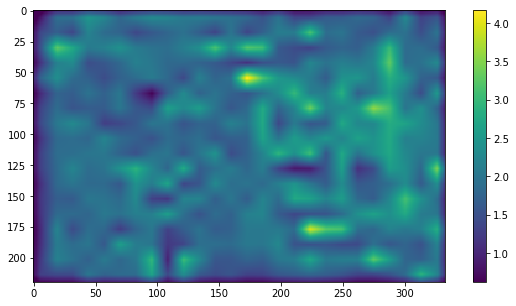

In [39]:
max_score, nose_r, nose_c, nose_scale, nose_response_map = \
    pyramid_score (image, nose_feature, nose_shape, step_size = 20,scale=0.9, pixel_per_cell = 2)

nose_response_map = resize(nose_response_map, face_response_map.shape)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(nose_r, nose_c))
plot_part5_1(nose_response_map)

Maximum HoG face feature score over pyramid and sliding window =  7.20625322590928
Maximum score location = row 0, col 20


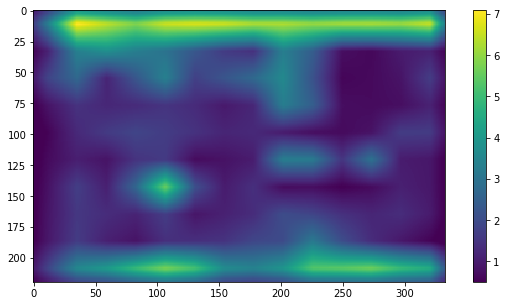

In [40]:
max_score, mouth_r, mouth_c, mouth_scale, mouth_response_map =\
    pyramid_score (image, mouth_feature, mouth_shape, step_size = 20,scale=0.9, pixel_per_cell = 2)

mouth_response_map = resize(mouth_response_map, face_response_map.shape)

print("Maximum HoG face feature score over pyramid and sliding window = ", max_score)
print("Maximum score location = row {}, col {}".format(mouth_r, mouth_c))
plot_part5_1(mouth_response_map)

###  4.2 Shift heatmap (5 points)

After getting the response maps for each part of the face, we will shift these maps so that they all have the same center as the face. We have calculated the shift vector mu in `compute_displacement`, so we are shifting based on vector mu. Implement `shift_heatmap` function in `detection.py`.

Heatmap face max and min =  1.0 0.23208590636050266
Heatmap face max location =  (96, 97)


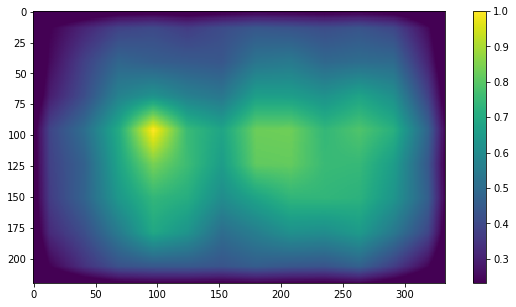

In [41]:
face_heatmap_shifted = shift_heatmap(face_response_map, [0,0])
print("Heatmap face max and min = ", face_heatmap_shifted.max(), face_heatmap_shifted.min())
print("Heatmap face max location = ", np.unravel_index(face_heatmap_shifted.argmax(), face_heatmap_shifted.shape))
plot_part5_2_face(face_heatmap_shifted)

Heatmap left eye max and min =  0.9966420811071118 0.0
Heatmap left eye max location =  (40, 203)
Heatmap right eye max and min =  1.0003137543274132 0.0
Heatmap right eye max location =  (40, 165)
Heatmap nose max and min =  1.0058910146338444 0.0
Heatmap nose max location =  (28, 173)
Heatmap mouth max and min =  0.7989907929328093 0.0
Heatmap mouth max location =  (165, 107)


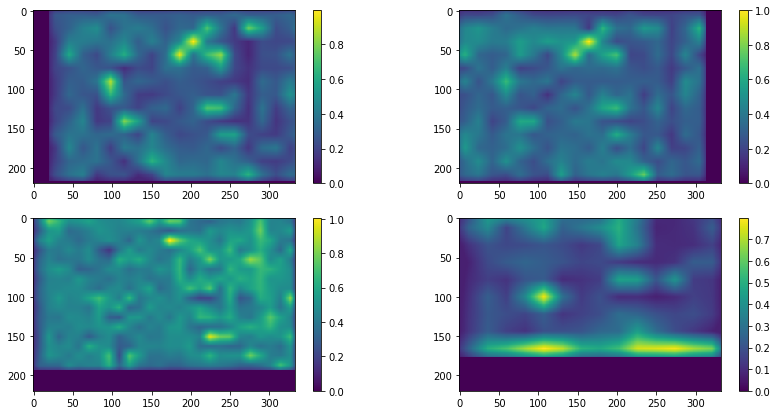

In [42]:
lefteye_heatmap_shifted = shift_heatmap(lefteye_response_map, lefteye_mu)
righteye_heatmap_shifted = shift_heatmap(righteye_response_map, righteye_mu)
nose_heatmap_shifted = shift_heatmap(nose_response_map, nose_mu)
mouth_heatmap_shifted = shift_heatmap(mouth_response_map, mouth_mu)

print("Heatmap left eye max and min = ", 
      lefteye_heatmap_shifted.max(), lefteye_heatmap_shifted.min())
print("Heatmap left eye max location = ", 
      np.unravel_index(lefteye_heatmap_shifted.argmax(), lefteye_heatmap_shifted.shape))

print("Heatmap right eye max and min = ", 
      righteye_heatmap_shifted.max(), righteye_heatmap_shifted.min())
print("Heatmap right eye max location = ", 
      np.unravel_index(righteye_heatmap_shifted.argmax(), righteye_heatmap_shifted.shape))

print("Heatmap nose max and min = ", 
      nose_heatmap_shifted.max(), nose_heatmap_shifted.min())
print("Heatmap nose max location = ", 
      np.unravel_index(nose_heatmap_shifted.argmax(), nose_heatmap_shifted.shape))

print("Heatmap mouth max and min = ", 
      mouth_heatmap_shifted.max(), mouth_heatmap_shifted.min())
print("Heatmap mouth max location = ", 
      np.unravel_index(mouth_heatmap_shifted.argmax(), mouth_heatmap_shifted.shape))

plot_part5_2_parts(lefteye_heatmap_shifted, righteye_heatmap_shifted,
                 nose_heatmap_shifted, mouth_heatmap_shifted)

# Part 5: Gaussian Filter (15 points)

## Part 5.1 Gaussian Filter (10 points)
In this part, apply gaussian filter convolution to each heatmap. Blur by kernel of standard deviation sigma, and then add the heatmaps of the parts with the heatmap of the face. On the combined heatmap, find the maximum value and its location. You can use function provided by skimage to implement **`gaussian_heatmap`**.


Heatmap shape =  (220, 333)
Image shape =  (344, 520)
Gaussian heatmap max and min =  3.161734031192428 0.2320870136277402
Gaussian heatmap max location =  (97, 98)
Resizing heatmap to image shape ...


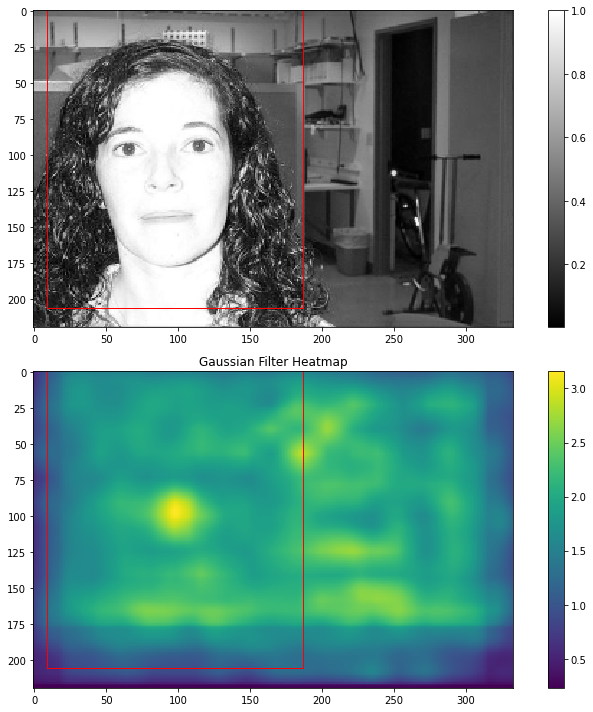

In [43]:
heatmap_face = face_heatmap_shifted

heatmaps = [lefteye_heatmap_shifted, 
           righteye_heatmap_shifted,
           nose_heatmap_shifted,
           mouth_heatmap_shifted]
sigmas = [lefteye_std, righteye_std, nose_std, mouth_std]

heatmap, i , j = gaussian_heatmap(heatmap_face, heatmaps, sigmas)
print("Heatmap shape = ", heatmap.shape)
print("Image shape = ", image.shape)
print("Gaussian heatmap max and min = ", heatmap.max(), heatmap.min())
print("Gaussian heatmap max location = ", np.unravel_index(heatmap.argmax(), heatmap.shape))

print("Resizing heatmap to image shape ...")
plot_part6_1(winH, winW, heatmap, image, i, j)

## 5.2 Result Analysis (5 points)

Does your DPM work on detecting human faces? Can you think of a case where DPM may work better than the detector we had in part 3 (sliding window + image pyramid)? You can also have examples that are not faces.

**Your Answer:** Write your answer in this markdown cell.

## Extra Credit
You have tried detecting one face from the image, and the next step is to extend it to detecting multiple occurences of the object. For example in the following image, how do you detect more than one face from your response map? Implement the function **`detect_multiple`**, and write code to visualize your detected faces in the cell below.

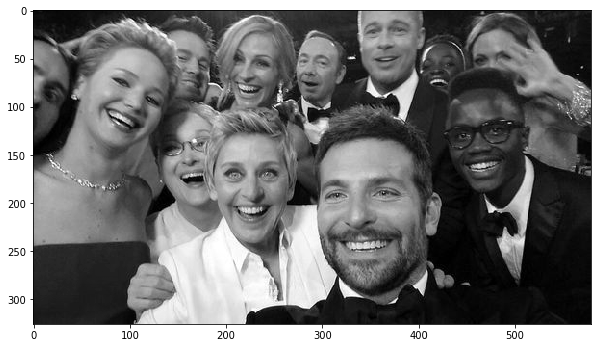

In [44]:
image_path = 'image_0002.jpg'
image = io.imread(image_path, as_gray=True)
plt.imshow(image)
plt.show()

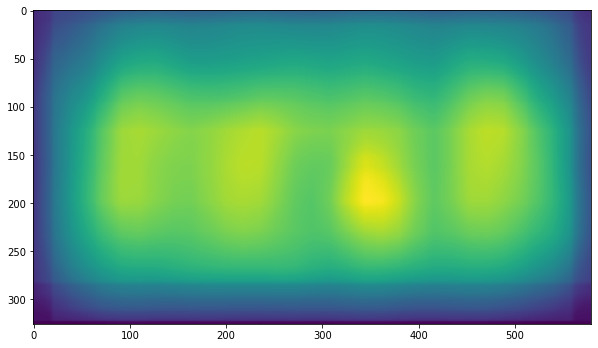

In [45]:
image_path = 'image_0002.jpg'
image = io.imread(image_path, as_gray=True)
heatmap = get_heatmap(image, face_feature, face_shape, detectors_list, parts)

plt.imshow(heatmap, cmap='viridis', interpolation='nearest')
plt.show()

In [47]:
detected_faces = detect_multiple(image, heatmap)

# Visualize your detected faces

### YOUR CODE HERE
pass
### END YOUR CODE

4.307031400959473 0.19646020868203296


---
# Part 6: K-Nearest Neighbors Classification (25 points)


## Face Dataset

We will use a dataset of faces of celebrities. Download the dataset using the following command:

    sh get_dataset.sh

The face dataset for CS131 assignment.
The directory containing the dataset has the following structure:

    faces/
        train/
            angelina jolie/
            anne hathaway/
            ...
        test/
            angelina jolie/
            anne hathaway/
            ...

Each class has 50 training images and 10 testing images.

In [2]:
from utils_knn import load_dataset

X_train, y_train, classes_train = load_dataset('faces', train=True, as_gray=True)
X_test, y_test, classes_test = load_dataset('faces', train=False, as_gray=True)

assert classes_train == classes_test
classes = classes_train

print('Class names:', classes)
print('Training data shape:', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape: ', y_test.shape)

Class names: ['angelina jolie', 'anne hathaway', 'barack obama', 'brad pitt', 'cristiano ronaldo', 'emma watson', 'george clooney', 'hillary clinton', 'jennifer aniston', 'johnny depp', 'justin timberlake', 'leonardo dicaprio', 'natalie portman', 'nicole kidman', 'scarlett johansson', 'tom cruise']
Training data shape: (800, 64, 64)
Training labels shape:  (800,)
Test data shape: (160, 64, 64)
Test labels shape:  (160,)


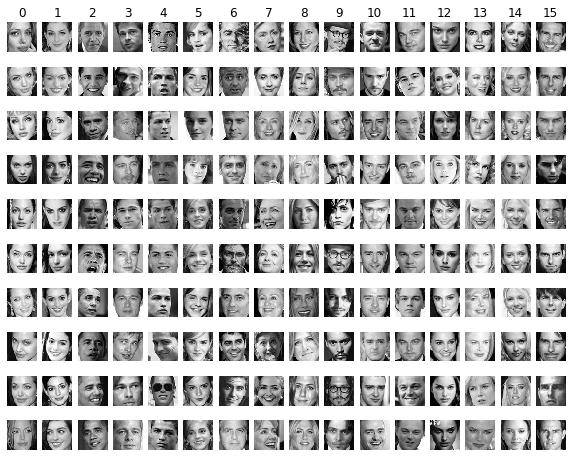

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

In [4]:
# Flatten the image data into rows
# we now have one 4096 dimensional featue vector for each example
X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))
X_test_flat = np.reshape(X_test, (X_test.shape[0], -1))
print("New training data shape:", X_train_flat.shape)
print("New test data shape:", X_test_flat.shape)

New training data shape: (800, 4096)
New test data shape: (160, 4096)


## Part 6.1: Cross Validation on Raw Pixel Features (15 Points)

We're now going to try to classify the test images using the k-nearest neighbors algorithm on the **raw features of the images** (i.e. the pixel values themselves). We will see later how we can use kNN on better features.

The gist of the k-nearest neighbors algorithm is to predict a test image's class based on which classes the k nearest train images belong to.  For example, using k = 3, if we found that for test image X, the three nearest train images were 2 pictures of Angelina Jolie, and one picture of Audrey Hepburn, we would predict that the test image X is a picture of Angelina Jolie.

Here are the steps that we will follow:

1. We compute the L2 distances between every element of X_test and every element of X_train in `compute_distances`.
2. We split the dataset into 5 folds for cross-validation in `split_folds`.
3. For each fold, and for different values of `k`, we predict the labels and measure accuracy.
4. Using the best `k` found through cross-validation, we measure accuracy on the test set.

Resources for understanding cross-validation:
https://towardsdatascience.com/why-and-how-to-cross-validate-a-model-d6424b45261f

In [5]:
from k_nearest_neighbor import compute_distances

# Step 1: compute the distances between all features from X_train and from X_test
dists = compute_distances(X_test_flat, X_train_flat)
assert dists.shape == (160, 800)
print("dists shape:", dists.shape)

dists shape: (160, 800)


In [6]:
from k_nearest_neighbor import predict_labels

# We use k = 1 (which corresponds to only taking the nearest neighbor to decide)
y_test_pred = predict_labels(dists, y_train, k=1)

# Compute and print the fraction of correctly predicted examples
num_test = y_test.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 38 / 160 correct => accuracy: 0.237500


### Cross-Validation

We don't know the best value for our parameter `k`.  
There is no theory on how to choose an optimal `k`, and the way to choose it is through cross-validation.

We **cannot** compute any metric on the test set to choose the best `k`, because we want our final test accuracy to reflect a real use case. This real use case would be a setting where we have new examples come and we classify them on the go. There is no way to check the accuracy beforehand on that set of test examples to determine `k`.

Cross-validation will make use split the data into different fold (5 here).  
For each fold, if we have a total of 5 folds we will have:
- 80% of the data as training data
- 20% of the data as validation data

We will compute the accuracy on the validation accuracy for each fold, and use the mean of these 5 accuracies to determine the best parameter `k`.

In [9]:
from k_nearest_neighbor import split_folds

# Step 2: split the data into 5 folds to perform cross-validation.
num_folds = 5

X_trains, y_trains, X_vals, y_vals = split_folds(X_train_flat, y_train, num_folds)

assert X_trains.shape == (5, 640, 4096)
assert y_trains.shape == (5, 640)
assert X_vals.shape == (5, 160, 4096)
assert y_vals.shape == (5, 160)

In [12]:
# Step 3: Measure the mean accuracy for each value of `k`

# List of k to choose from
k_choices = list(range(5, 101, 5))

# Dictionnary mapping k values to accuracies
# For each k value, we will have `num_folds` accuracies to compute
# k_to_accuracies[1] will be for instance [0.22, 0.23, 0.19, 0.25, 0.20] for 5 folds
k_to_accuracies = {}

for k in k_choices:
    print("Running for k=%d" % k)
    accuracies = []
    for i in range(num_folds):
        # Make predictions
        fold_dists = compute_distances(X_vals[i], X_trains[i])
        y_pred = predict_labels(fold_dists, y_trains[i], k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_pred == y_vals[i])
        accuracy = float(num_correct) / len(y_vals[i])
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies
    #print(accuracies)

Running for k=5
Running for k=10
Running for k=15
Running for k=20
Running for k=25
Running for k=30
Running for k=35
Running for k=40
Running for k=45
Running for k=50
Running for k=55
Running for k=60
Running for k=65
Running for k=70
Running for k=75
Running for k=80
Running for k=85
Running for k=90
Running for k=95
Running for k=100


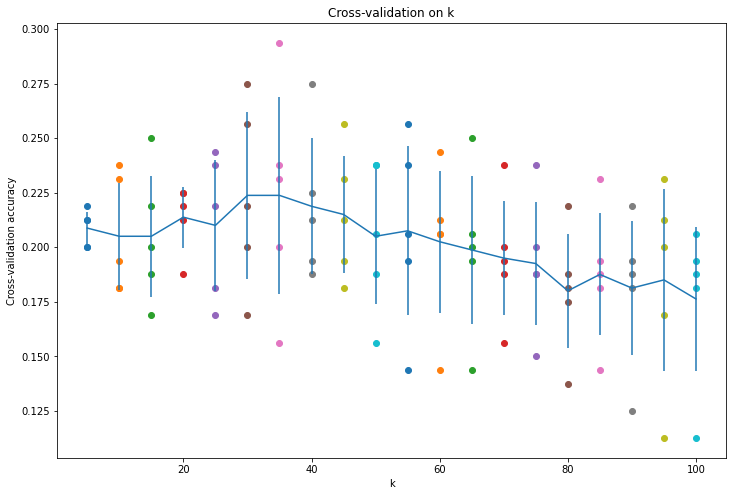

In [13]:
# plot the raw observations
plt.figure(figsize=(12,8))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [20]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 26% accuracy on the test data.

best_k = None
### YOUR CODE HERE
# Choose the best k based on the cross validation above
best_k = 35
### END YOUR CODE

y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('For k = %d, got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

For k = 35, got 46 / 160 correct => accuracy: 0.287500


## Part 6.2: Cross Validation on HOG Features (10 Points)

We're now going to try to classify the test images using the k-nearest neighbors algorithm on HOG features!

In [21]:
# Create HOG datasets
X_train_hog = [hog_feature(x)[0] for x in X_train]
X_test_hog = [hog_feature(x)[0] for x in X_test]
print("Loaded {} HoG features.".format(len(X_train_hog)))
print("Loaded {} HoG features.".format(len(X_test_hog)))

X_train_hog = np.stack(X_train_hog)
X_test_hog = np.stack(X_test_hog)
print("HOG Training data shape:", X_train_hog.shape)
print("HOG Test data shape:", X_test_hog.shape)

Loaded 800 HoG features.
Loaded 160 HoG features.
HOG Training data shape: (800, 2916)
HOG Test data shape: (160, 2916)


Running for k=5
Running for k=10
Running for k=15
Running for k=20
Running for k=25
Running for k=30
Running for k=35
Running for k=40
Running for k=45
Running for k=50
Running for k=55
Running for k=60
Running for k=65
Running for k=70
Running for k=75
Running for k=80
Running for k=85
Running for k=90
Running for k=95
Running for k=100


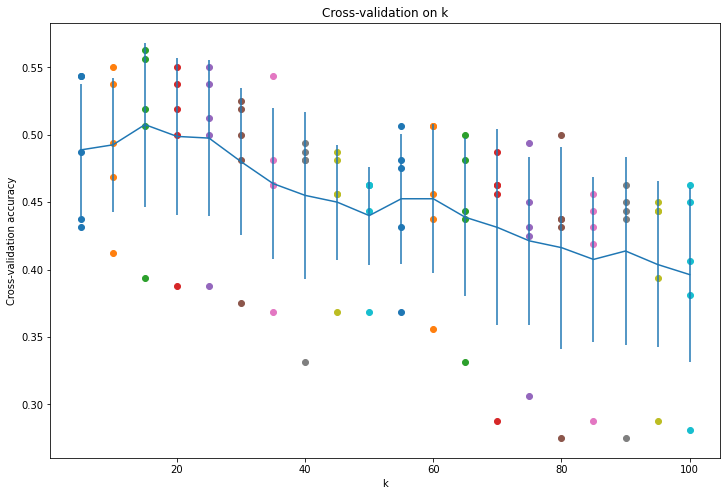

In [22]:
# Create Cross Validation datasets
num_folds = 5
X_hog_trains, y_trains, X_hog_vals, y_vals = split_folds(X_train_hog, y_train, num_folds)

    
# List of k to choose from
k_choices = list(range(5, 101, 5))
k_to_accuracies = {}

for k in k_choices:
    print("Running for k=%d" % k)
    accuracies = []
    for i in range(num_folds):
        # Make predictions
        fold_dists = compute_distances(X_hog_vals[i], X_hog_trains[i])
        y_pred = predict_labels(fold_dists, y_trains[i], k)

        # Compute and print the fraction of correctly predicted examples
        num_correct = np.sum(y_pred == y_vals[i])
        accuracy = float(num_correct) / len(y_vals[i])
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies
    
    
# plot the raw observations
plt.figure(figsize=(12,8))
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()


In [23]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 50% accuracy on the test data.

best_k = None
### YOUR CODE HERE
# Choose the best k based on the cross validation above
best_k = 15
### END YOUR CODE

dists = compute_distances(X_test_hog, X_train_hog)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_test = X_test_hog.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('For k = %d, got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

For k = 15, got 89 / 160 correct => accuracy: 0.556250


### Written Questions
**Guidance on expectations and grading:**   
These are fairly open-ended questions that don't have a black and white, right or wrong answer. Instead, there are many ways of reasoning about these questions, and we're looking for engagement with and understanding of the purpose and mechanics of HOG, K-Nearest Neighbors, Cross Validation, and splitting data into training, validation, and testing sets. As long as you meaningfully engage with these concepts, as they're relevant to each question, and show understanding of them, you'll earn full credit!

**Here's some clarification on Question 3:**  
We mention a variety of performance metrics for each value of k on the cross validation results: mean, standard deviation, maximum, and minimum. Mean is represented by the middle of each error bar that has the horizontal blue line connecting all the means for each value of k, while standard deviation is the size of the error bar. Mean is the average accuracy of that value of k across all of the cross validation splits, and standard deviation is also measured across the cross validation splits. You only need to consider one of these factors to inform your choice of the 'best' k, but you're free to consider multiple or all of them in your reasoning about choosing the 'best' k. You can get full credit for accurately defending the use of any combination of these metrics.

If you're stuck on Question 3, think about these questions to get you started:   
*Hint 1:* for a given value of k, what does the mean of validation set accuracy tell you about expected test set accuracy with that value of k? What does the standard deviation of validation set accuracy tell you about the uncertainty of test set accuracy with that value of k?   
*Hint 2:* you can also similarly think about minimum and maximum accuracy across the splits for a given value of k, which relates to standard deviation.


**Question 1**: Why did HOG features do so much better than raw pixels? You'll notice that even the luckiest high outlier of cross validation on raw pixels is outperformed by the unluckiest low outlier in HOG. Remember that the goal of this classification task is to learn to classify the identity of a profile picture using the selected feature type. How do you think we could improve to do even better?

**Your Answer:** Write your answer in this markdown cell.
Either of both of these answers is correct, or something new as long as it demonstrates some understanding of HoG features and KNN



**Question 2**: Why did we tell you to choose the best k from cross validation, and then evaluate accuracy for that k on the test set, instead of directly evaluating a range of k values on the test set and picking the one with the best accuracy?

**Your Answer:** Write your answer in this markdown cell.



**Question 3**: How did you decide which value of k was 'best'? In a real-world scenario, if you were deploying this K-Nearest Neighbors HOG feature classifier, how would you consider the roles of the mean, standard deviation, maximum, and/or minimum of each value of k that you observed in cross validation when choosing the 'best' k?

**Your Answer:** Write your answer in this markdown cell.

